# Generating returns
We use the label $t$ to refer to both a point in _time_, as well as the _time interval_ or _time period_ from time $t$ to $t + 1$. (**Draw a timeline and indicate the times $t-1$, $t$ and $t+1$ and the time periods $t-1$ and $t$.**)

Let $P_{i,t}$ denote the price of asset $i=1,\ldots,n$, which pays no divides, at times $t=1,\ldots,T+1$. 

The _net return_, $R_{i,t}$, for time period $t$, for asset $i$, is defined as
$$
R_{i,t} = \frac{P_{i,t+1}-P_{i,t}}{P_{i,t}} =  \frac{P_{i,t+1}}{P_{i,t}} - 1, \quad \forall i=1,\ldots,n \text{ and } \forall t = 1,\ldots,T.
$$

The _gross return_ on asset $i$ for time period $t$ is defined as 
$$
1+R_{i,t} = \frac{P_{i,t+1}}{P_{i,t}}, \quad \forall i=1,\ldots,n \text{ and } \forall t = 1,\ldots,T.
$$

The _continuousy compunded return_ or _log return_, $r_{i,t}$, on asset $i$ for time period $t$ is defined as the natural logarithm of the gross return, i.e.
$$
r_{i,t} = \ln(1+R_{i,t}) = \ln \left(\frac{P_{i,t+1}}{P_{i,t}}\right), \quad \forall i=1,\ldots,n \text{ and } \forall t = 1,\ldots,T.
$$

Let 
$$
P_{t} = 
\begin{bmatrix}
P_{1,t} \\
\vdots \\
P_{n,t} \\
\end{bmatrix}, \quad \forall t = 1,\ldots,T+1, \\
R_{t}=
\begin{bmatrix}
R_{1,t} \\
\vdots \\
R_{n,t} \\
\end{bmatrix}, \quad \forall t = 1,\ldots,T, \\
r_{t}=
\begin{bmatrix}
r_{1,t} \\
\vdots \\
r_{n,t} \\
\end{bmatrix}, \quad \forall t = 1,\ldots,T.
$$
---
The following code gererates simulated log returns $r_{t}$ such that
$$
r_{t} \stackrel{\text{iid}}{\sim} \mathcal{N}\left(\tilde{\mu},\tilde{\Sigma}\right),\quad \forall t=1,\ldots,T
$$
for some randomly chosen $\tilde{\mu}\in\mathbb{R}^{n}$ and $\tilde{\Sigma}\in\mathbb{S}_{++}^{n}$.

In [1]:
import numpy as np
from numpy.random import default_rng
rng = default_rng(1)

T = 10000 # number of trading periods.
n = 30 # number of stocks

mu_tilde = 0.0001*(rng.random(n)-0.5)
temp = rng.normal(0,0.01,(n,n))
Sigma_tilde = 0.01 * (temp.T @ temp + 0.0001 * np.eye(n))
r = rng.multivariate_normal(mu_tilde,Sigma_tilde,T)

Typically, you do not have access to $\tilde\mu$ and $\tilde\Sigma$, i.e. these model parameters need to be estimated directly or indirectly. More fundamentally, assuming iid normality on the log returns is computationally tractable, but not necessarily true empirically. 

--- 

The following code calculates the simple net returns $R_{t}$

In [2]:
R = np.exp(r) - 1

The expected simple net return $\mu=\operatorname{\mathbb{E}}[ R_{t}]\in\mathbb{R}^{n}$ and the covariance matrix of the simple net return $\Sigma=\operatorname{Var}[ R_{t}]\in\mathbb{S}_{++}^{n}$ are given by 
$$
\mu_i=\exp\left(\tilde\mu_i+\frac{1}{2}\tilde\Sigma_{ii}\right)-1,\quad \forall i = 1,\ldots,n 
$$
and
$$
\Sigma_{ij}=\exp\left(\tilde\mu_i+\tilde\mu_j + \frac{1}{2}\left(\tilde\Sigma_{ii}+\tilde\Sigma_{jj}\right) \right)\left( \exp\left(\tilde\Sigma_{ij}\right) - 1\right),\quad \forall i,j = 1,\ldots,n
$$
respectively (show this if you want to). These quantities are calculated below.

In [3]:
mu = np.exp(mu_tilde + 0.5 * np.diag(Sigma_tilde)) - 1
Sigma = np.exp(mu_tilde.reshape(n, 1) @ np.ones((1,n))
               + np.ones((n,1)) @ mu_tilde.reshape(1, n)
               + 0.5 * np.diag(Sigma_tilde).reshape(n, 1) @ np.ones((1,n))
               + 0.5 * np.ones((n,1)) @ np.diag(Sigma_tilde).reshape(1,n)
              ) * np.exp(Sigma_tilde-1)

--- 

If we wish, we can generate a price time series $\{P_{t}\}_{t=1}^{T+1}$ as below.

In [4]:
P_0 = rng.integers(low=100, high=1000, size=n)
P = np.ndarray((T+1,n))
P[0,:] = P_0
for t in range(T):
    P[t+1,:] = (R[t,:]+1)*P[t,:]

Below is a simple figure showing the prices $P_{t}$.

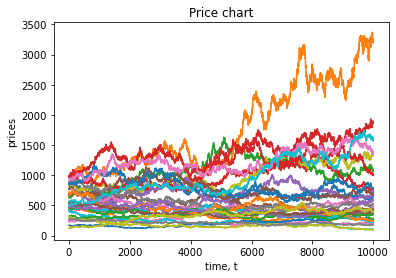

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, axes = plt.subplots()
axes.plot(P)
axes.set_xlabel('time, t')
axes.set_ylabel('prices')
axes.set_title('Price chart');

However, we are not primarily intrested in the prices $P_{t}$, but rather the returns $R_{t}$.

# Single-period portfolio dynamics
This section is based on "[Multi-Period Trading via Convex Optimization](https://arxiv.org/pdf/1705.00109.pdf)" Boyd et al. (**Beware: the version below assumes zero transaction cost, zero holding cost and does not contain a risk-free asses/cash balance. Therefore, the notation deviates slightly from that of Boyd et al.**)


### Portfolio at time $t$
Let $h_{i,t}$ denote the _SEK value invested_ in asset $i=1,\ldots,n$ at time $t=1,\ldots,T+1$. Let 
$$
h_{t}=
\begin{bmatrix}
h_{1,t} \\
\vdots \\
h_{n,t} \\
\end{bmatrix}, \quad \forall t = 1,\ldots,T+1.
$$

The _total value_ or _net asset value_ (NAV) $v_t$ of the portfolio, in SEK, at time $t$, is defines as
$$
v_{t} = \mathbb{1}^{T}h_{t} = \sum_{i=1}^{n}h_{i,t}, \quad \forall t = 1,\ldots,T+1.
$$
We assume that 
$$
v_{t} > 0, \quad \forall t = 1,\ldots,T+1.
$$

We define the _weight_ $w_{i,t}$ in asset $i$, at time $t$, as 
$$
w_{i,t} = \frac{h_{i,t}}{v_{t}}, \quad \forall i=1,\ldots,n \text{ and } \forall t = 1,\ldots,T+1.
$$
Let 
$$
w_{t}=
\begin{bmatrix}
w_{1,t} \\
\vdots \\
w_{n,t} \\
\end{bmatrix}, \quad \forall t = 1,\ldots,T+1.
$$

### Post-trade portfolio at time $t$

Let $u_{i,t}$ denote the _SEK value traded_ in asset $i=1,\ldots,n$, exactly at the beginning of time period $t=1,\ldots,T$. We assume perfect and instantaneous trade execution. (**Draw a timeline and indicate the temporal position of $u_{i,t}$**.) Let 
$$
u_{t}=
\begin{bmatrix}
u_{1,t} \\
\vdots \\
u_{n,t} \\
\end{bmatrix}, \quad \forall t = 1,\ldots,T.
$$
We assume zero transaction cost and that no external cash is put into or taken out at each time period $t = 1,\ldots,T$. This assumtion implies that 
$$
\mathbb{1}^{T}u_{t} = 0, \quad \forall t = 1,\ldots,T.
$$
This is a so-called _self-financing condition_.


We define the _normalized trade_ $z_{i,t}$ in asset $i$ at time $t$ as 
$$
z_{i,t} = \frac{u_{i,t}}{v_{t}}, \quad \forall i=1,\ldots,n \text{ and } \forall t = 1,\ldots,T.
$$
Let 
$$
z_{t}=
\begin{bmatrix}
z_{1,t} \\
\vdots \\
z_{n,t} \\
\end{bmatrix}, \quad \forall t = 1,\ldots,T.
$$
Clearly,
$$
\mathbb{1}^{T}z_{t} = 0, \quad \forall t = 1,\ldots,T.
$$

The _post-trade portfolio_ $h_{t}^{+}$, given exactly at the beginning of time period $t$, is defined as 
$$
h_{t}^{+} = h_{t} + u_{t}, \quad \forall t = 1,\ldots,T.
$$

Note that _post-trade total value_ of the portfolio, in SEK, given exactly at the beginning of time period $t$, is just $v_{t}$, since
$$
\mathbb{1}^{T}h_{t}^{+} = \mathbb{1}^{T}(h_{t} + u_{t}) = \mathbb{1}^{T}h_{t} + \mathbb{1}^{T} u_{t} = \mathbb{1}^{T}h_{t} = v_{t}, \quad \forall t = 1,\ldots,T.
$$

Define the _post-trade weights_ $w_{t}^{+}$, at time $t$, as 
$$
w_{t}^{+} = \frac{h_{t}^{+}}{v_{t}}, \quad \forall t = 1,\ldots,T,
$$
with elementwise division. Note that 
$$
w_{t}^{+} =   w_{t} + z_{t}, \quad \forall t = 1,\ldots,T.
$$

### Period portfolio at time $t+1$

Note that it must hold that 
$$
h_{t+1} = (\mathbb{1} + R_{t}) \odot  h_{t}^{+},\quad \forall t = 1,\ldots,T.
$$

Moreover, note that 
$$
v_{t+1} = \mathbb{1}^{T}h_{t+1} = (\mathbb{1} + R_{t})^{T}h_{t}^{+} = \mathbb{1}^{T}h_{t}^{+} + R_{t}^{T}h_{t}^{+} = \mathbb{1}^{T}(h_{t} + u_{t}) + R_{t}^{T}(h_{t} + u_{t}) = v_{t} + R_{t}^{T}h_{t} + R_{t}^{T}u_{t}, \quad \forall t = 1,\ldots,T.
$$

The _realized portfolio return_ $R_{t}^{P}$ for time period $t$ is defined
$$
R_{t}^{P} = \frac{v_{t+1}-v_{t}}{v_{t}},\quad \forall t = 1,\ldots,T.
$$
We see that
$$
R_{t}^{P} = R_{t}^{T}w_{t} + R_{t}^{T}z_{t},\quad \forall t = 1,\ldots,T.
$$

We have the following relationship for the next period weights $w_{t+1}$:
$$
w_{t+1} = \frac{h_{t+1}}{v_{t+1}} = \frac{1}{v_{t+1}} (\mathbb{1} + R_{t}) \odot  h_{t}^{+} = \frac{1}{v_{t+1}} (\mathbb{1} + R_{t}) \odot  (h_{t} + u_{t}) = \frac{v_{t}}{v_{t+1}} (\mathbb{1} + R_{t}) \odot  (w_{t} + z_{t}) = \frac{1}{1+R_{t}^{P}} (\mathbb{1} + R_{t}) \odot w_{t}^{+}, \quad \forall t = 1,\ldots,T.
$$

Note that if $R_{t} \approx 0$ (which typically is the case for daily trading data), then $R^{P}_{t} \approx 0$ and in particular $w_{t+1}\approx w_{t}^{+}$. This will be importat for the multi-period trading case. However, it is not necessary to use this approximation in the single-period trading case.

### Performance metrics
The _average realized portfolio return_ is given by
$$
\overline{R^{P}_{t}} = \frac{1}{T}\sum_{t=1}^{T}R_{t}^{P}.
$$

The _realized portfolio volatility_ or the _(uncorrected) sample standard deviation_ of the portfolio returns is given by
$$
\widehat{\sigma}^{P} = \sqrt{\frac{1}{T}\sum_{t=1}^{T}(R_{t}^{P}-\overline{R^{P}_{t}})^{2}}.
$$

Assuming that the risk-free rate is zero, the _ex-post Sharpe ratio_ or _realized Sharpe ratio_ SR is given by
$$
SR = \frac{\overline{R^{P}_{t}}}{\widehat{\sigma}^{P}}.
$$

The _average turnover_ is given by
$$
\overline{\text{turnover}} = \frac{1}{T}\sum_{t=1}^{T}\frac{\left\lVert z_{t} \right\rVert_{1} }{2}.
$$

Students are welcome to find additonal performance metrics in the literature.

### Trade selection
It  remains to specify the SEK value traded $u_{t}$, or equivalently, the normalized trades $z_{t}$, for each time $t=1,\ldots,T$. Note from above that the realized portfolio return $R_{t}^{P}$ for time period $t$ is given by 
$$
R_{t}^{P} = R_{t}^{T}w_{t} + R_{t}^{T}z_{t},\quad \forall t = 1,\ldots,T.
$$
At time $t$, we do not know the value of $R_{t}$. However, we can hope to esimate $R_{t}$ with, say $R_{t|t}=\operatorname{\mathbb{E}_{t}}[R_{t}]$, where the index $t$ in the expectation indicates that we condition on all information known up to time $t$. Why is this useful? Note that 
$$
\operatorname{\mathbb{E}_{t}}[R_{t}^{P}] = R_{t|t}^{T}w_{t} + R_{t|t}^{T}z_{t},\quad \forall t = 1,\ldots,T.
$$
Thus, we can maximise $\operatorname{\mathbb{E}_{t}}[R_{t}^{P}]$ with respect to $z_{t}$, under the contraint that $\mathbb{1}^{T}z_{t}=1$, to get the normalized trades. **Why is this a bad idea?**

Usually, we would like to compensate for the risk in the portfolio returns also. Note that 
$$
\operatorname{Var_{t}}[R_{t}^{P}] = (w_{t}+z_{t})^{T}\operatorname{Var_{t}}[R_{t}](w_{t}+z_{t}) = (w_{t}+z_{t})^{T}\Sigma_{t|t}(w_{t}+z_{t}),\quad \forall t = 1,\ldots,T.
$$

Thus, we would like to maximise 
$$
\operatorname{\mathbb{E}_{t}}[R_{t}^{P}] - \gamma \operatorname{Var_{t}}[R_{t}^{P}]
$$
with respect to $z_{t}$, under the contraint that $\mathbb{1}^{T}z_{t}=1$. Here, $\gamma>0$ is a _risk aversion parameter_ selected by us. Values $\gamma \geq 1/2$ are common.

In addition, we would like to add the no short-sale constraint 
$$
w_{t}+z_{t} \geq 0.
$$ 

Hence, we would like to pick the $z_{t}$ that solves the optimization problem
$$
\begin{equation}
\begin{aligned}
& \underset{z_{t}\in\mathbb{R}^{n}}{\mathrm{maximize}}
& & R_{t|t}^{T}z_{t} - \gamma (w_{t}+z_{t})^{T}\Sigma_{t|t}(w_{t}+z_{t}) \\
& \text{subject to}
& &  \mathbb{1}^{T}z_{t}=0, \\
& & &  w_{t}+z_{t} \geq 0, \\
\end{aligned}
\end{equation}
$$
for each time $t=1\ldots,T$. However, $R_{t|t}$ and $\Sigma_{t|t}$ are typically not known, but can be replaced by approprate estimates $\hat R_{t|t}$ and $\hat\Sigma_{t|t}$, respectively. Thus, we arrive at the final problem 
$$
\begin{equation}
\begin{aligned}
& \underset{z_{t}\in\mathbb{R}^{n}}{\mathrm{maximize}}
& & \hat R_{t|t}^{T}z_{t} - \gamma (w_{t}+z_{t})^{T}\hat\Sigma_{t|t}(w_{t}+z_{t}) \\
& \text{subject to}
& &  \mathbb{1}^{T}z_{t}=0, \\
& & &  w_{t}+z_{t} \geq 0, \\
\end{aligned}
\end{equation}
$$
that needs to be solved for each time $t=1\ldots,T$.

# Example on simulated data using true values
In our particular example, we happen to know $R_{t|t}$ and $\Sigma_{t|t}$ exacly, since we simulated the data ourself. In fact, they are given by
$$
\begin{align}
R_{t|t} &= \operatorname{\mathbb{E}_{t}}[R_{t}] = \operatorname{\mathbb{E}}[R_{t}] = \mu , \quad \forall t = 1,\ldots,T, \\
\Sigma_{t|t} &= \operatorname{Var_{t}}[R_{t}] = \operatorname{Var}[R_{t}] = \Sigma , \quad \forall t = 1,\ldots,T,
\end{align}
$$
since the (log) returns where simulated as iid (Gaussian). Note that they are time independent.

Below we simulate the evolution of a portfolio with initial total value $v_{0} = 1000000$ SEK, uniformly allocated across the $n$ asssets, i.e. $w_{0} = \frac{1}{n}\mathbb{1}$, using the trade selection stratagy above.

SR 0.36040945529312374
Average turnover 0.513247719099622


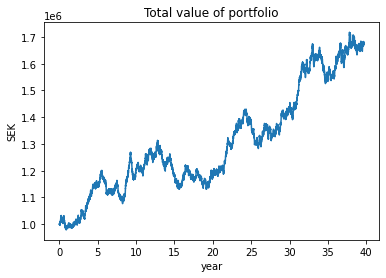

In [6]:
import cvxpy as cp

def get_normalized_trades(hat_R, hat_Sigma, w, gamma=0.5):
    n = np.size(hat_R)
    z = cp.Variable(n)
    objective = cp.Maximize(hat_R.T@z - gamma*cp.quad_form(w+z, hat_Sigma))
    constraints = [cp.sum(z) == 0, w + z >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    z = z.value
    return z

v = np.zeros(T+1)
v[0] = 1000000
R_P = np.zeros(T)
w = np.ones(n) / n
z = get_normalized_trades(mu, Sigma, w)
R_P[0] = R[0].T @ (w + z)
v[1] = v[0] * (1 + R[0].T @ (w + z))
turnover = np.linalg.norm(z,ord=1)/2
for t in range(T-1):
    w =  (1 + R[t]) * (w + z) / (1+R_P[t])
    z = get_normalized_trades(mu, Sigma, w)
    R_P[t+1] = R[t+1].T @ (w + z)
    v[t+2] = v[t+1] * (1 + R[t+1].T @ (w + z))
    turnover += np.linalg.norm(z,ord=1)/2
turnover /= T

fig, axes = plt.subplots()
axes.plot(np.arange(T+1)/252, v)
axes.set_xlabel('year')
axes.set_ylabel('SEK')
axes.set_title('Total value of portfolio');

average_realized_portfolio_return = np.mean(R_P)
realized_portfolio_volatility = np.std(R_P)
print('SR', average_realized_portfolio_return/realized_portfolio_volatility*np.sqrt(252)) #annualized
print('Average turnover', turnover*252) #annualized

# Forecasting expected returns and the covariance matrix

## Returns

Below we present two very simple (and usualy poor performing on historical data) estimates $\hat R_{t|t}$ of the expected returns $R_{t|t}$. These are meant as a starting point for further __independet__ exploration.

#### Simple moving average (SMA)

Let $T_{\text{SMA}}\in\mathbb{N}$ and
$$
\hat R_{t|t}^{\text{SMA}} = \frac{1}{T_{\text{SMA}}} \sum_{i = 1}^{T_{\text{SMA}}} R_{t-i}, \quad \forall t = T_{\text{SMA}} + 1,\ldots T.
$$
Here you will need to decied on an approprate $T_{\text{SMA}}$. Remark: this estimate is never used in practice due to its extremely poor performance.

#### Exponentially weighted moving average (EMA)

Let $\alpha_{\text{EMA}}\in (0,1)$ and
$$
\begin{align}
    \hat R_{t|t}^{\text{EMA}} = 
    \begin{cases}
    R_{t-1},              & \text{if } t = 2, \\
    \alpha_{\text{EMA}} \hat R_{t-1|t-1}^{\text{EMA}} + (1 - \alpha_{\text{EMA}}) R_{t-1},              & \text{if } 2 < t \leq T.
    \end{cases}
\end{align}
$$
Often, a variable $\tau_{\text{EMA}}\in\mathbb{N}$ is introduced such that 
$$
\begin{align*}
    \alpha_{\text{EMA}} = 1 - \frac{1}{\tau_{\text{EMA}} + 1},
\end{align*}
$$
The varialble $\tau_{\text{EMA}}$ can be interpreted as the temporal center of mass of the exponential moving average. A good staring point is testing $\tau_{\text{EMA}} \approx 25$. Note that this estimate requiers a _burn in period_ i.e. disregarding the first $2\tau_{\text{EMA}}$ samples is a rule that can be used. Remark: this estimate is never used in practice due to its poor performance.

## Covariance matrix

Below we present two simple estimates $\hat \Sigma_{t|t}$ of the covariance matrix $\Sigma_{t|t}$ and one common regularization method widly used both in academia and industry.

#### Sample covariance matrix (SCM)

Let $T_{\text{SCM}}\in\mathbb{N}$ and
$$
\begin{align}\label{eq:scm}\tag{1}
\hat \Sigma_{t|t}^{\text{SCM}} = \frac{1}{T_{\text{SCM}}} \sum_{i = 1}^{T_{\text{SCM}}} R_{t-i}R_{t-i}^{T}, \quad \forall t = T_{\text{SCM}} + 1,\ldots T.
\end{align}
$$
Here you will need to decied on an approprate $T_{\text{SCM}}$.

#### Exponential weighted moving average covariance matrix  (EMACM)

Let $\alpha_{\text{EMACM}}\in (0,1)$ and
$$
\begin{align}\label{eq:emacm}\tag{2}
    \hat \Sigma_{t|t}^{\text{EMACM}} = 
    \begin{cases}
    R_{t-1}R_{t-1}^{T},              & \text{if } t = 2, \\
    \alpha_{\text{EMACM}} \hat \Sigma_{t-1|t-1}^{\text{EMACM}} + (1 - \alpha_{\text{EMACM}}) R_{t-1}R_{t-1}^{T},              & \text{if } 2 < t \leq T.
    \end{cases}
\end{align}
$$
Often, a variable $\tau_{\text{EMACM}}\in\mathbb{N}$ is introduced such that 
$$
\begin{align*}
    \alpha_{\text{EMACM}} = 1 - \frac{1}{\tau_{\text{EMACM}} + 1},
\end{align*}
$$
The varialble $\tau_{\text{EMACM}}$ can be interpreted as the temporal center of mass of the exponential moving average covariance matrix. A good staring point is testing $\tau_{\text{EMACM}} \approx 250$. Note that this estimate requiers a _burn in period_ i.e. disregarding the first $2\tau_{\text{EMACM}}$ samples is a rule that can be used.


#### Ledoit and Wolf (2004)

The regularization method presented here is based on "[A well-conditioned estimator for large-dimensional covariance matrices](http://perso.ens-lyon.fr/patrick.flandrin/LedoitWolf_JMA2004.pdf)" by Olivier Ledoit and Michael Wolf.

First we present LW+SCM:

$$
\begin{align*}
    \hat\Sigma_{t|t}^{\text{LW+SCM}} = \beta_{1} \hat\Sigma_{t|t}^{\text{SCM}} + (1-\beta_{1}) \mu_{1} I,
\end{align*}
$$
where $\hat\Sigma_{t|t}^{\text{SCM}}$ is the sample covariance matrix given in \eqref{eq:scm}. Ledoit and Wolf suggestes using the parameters
$$
\begin{align*}
    \begin{cases}
    \mu_{1} &= n^{-1}\text{tr }\hat\Sigma_{t|t}^{\text{SCM}}, \\ 
    \beta_{1} &= 1 - \frac{\min\left(T_{\text{SCM}}^{-2}\sum_{i=1}^{T_{\text{SCM}}}\left\lVert R_{t-i}R_{t-i}^{T} - \hat\Sigma_{t|t}^{\text{SCM}}\right\rVert_{F}^{2},\,\left\lVert\hat\Sigma_{t|t}^{\text{SCM}}-\mu_{1} I\right\rVert_{F}^{2}\right)}{\left\lVert\hat\Sigma_{t|t}^{\text{SCM}}-\mu_{1} I\right\rVert_{F}^{2}},
    \end{cases}
\end{align*}
$$
where $\left\lVert\cdot\right\rVert_{F}$ is the Frobenius norm.


Next we present LW+EMACM:

$$
\begin{align*}
    \hat\Sigma_{t|t}^{\text{LW+EMACM}} = \beta_{2} \hat\Sigma_{t|t}^{\text{EMACM}} + (1-\beta_{2}) \mu_{2} I,
\end{align*}
$$
where $\hat\Sigma_{t|t}^{\text{EMACM}}$ is the exponential weighted moving average covariance matrix given in \eqref{eq:emacm}. The parameter $\mu_{2}$ can be chosen as
$$
\begin{align*}
    \mu_{2} &= n^{-1}\text{tr }\hat\Sigma_{t|t}^{\text{EMACM}}.
\end{align*}
$$
However, the parameter $\beta_{2}\in(0,1)$ needs to be tuned by the user.
